https://www.kaggle.com/datasets/shilongzhuang/pizza-sales

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
import catboost
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style('darkgrid')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

In [2]:
data = pd.read_excel("./data/raw/Data Model - Pizza Sales.xlsx")

In [3]:
data.shape

(48620, 12)

In [4]:
# good no duplications
data.duplicated().sum()

0

In [5]:
data.head(3)

,order_details_id,order_id,pizza_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,2015-01-01,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza


In [6]:
data.isna().sum()

order_details_id     0
order_id             0
pizza_id             0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
dtype: int64

In [7]:
# dropping record id
data = data.drop("order_details_id", axis=1)
data

,order_id,pizza_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,2,five_cheese_l,1,2015-01-01,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,2,ital_supr_l,1,2015-01-01,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,2,mexicana_m,1,2015-01-01,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza
...,...,...,...,...,...,...,...,...,...,...,...
48615,21348,ckn_alfredo_m,1,2015-12-31,21:23:10,16.75,16.75,M,Chicken,"Chicken, Red Onions, Red Peppers, Mushrooms, A...",The Chicken Alfredo Pizza
48616,21348,four_cheese_l,1,2015-12-31,21:23:10,17.95,17.95,L,Veggie,"Ricotta Cheese, Gorgonzola Piccante Cheese, Mo...",The Four Cheese Pizza
48617,21348,napolitana_s,1,2015-12-31,21:23:10,12.00,12.00,S,Classic,"Tomatoes, Anchovies, Green Olives, Red Onions,...",The Napolitana Pizza
48618,21349,mexicana_l,1,2015-12-31,22:09:54,20.25,20.25,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [8]:
data['pizza_id'].nunique(), data['pizza_name'].nunique()

(91, 32)

In [9]:
data['order_id'] = data['order_id'].astype(str)

We need to convert some columns to their suited data type
- `order_id` to object (string).

In [10]:
data.dtypes

order_id                     object
pizza_id                     object
quantity                      int64
order_date           datetime64[ns]
order_time                   object
unit_price                  float64
total_price                 float64
pizza_size                   object
pizza_category               object
pizza_ingredients            object
pizza_name                   object
dtype: object

In [11]:
data['order_date'].min(), data['order_date'].max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2015-12-31 00:00:00'))

In [12]:
data.dtypes

order_id                     object
pizza_id                     object
quantity                      int64
order_date           datetime64[ns]
order_time                   object
unit_price                  float64
total_price                 float64
pizza_size                   object
pizza_category               object
pizza_ingredients            object
pizza_name                   object
dtype: object

## EDA

How many sizes are there?

In [13]:
data['pizza_size'].unique()

array(['M', 'L', 'S', 'XL', 'XXL'], dtype=object)

In [14]:
pizza_sizes = data.groupby(['pizza_name'], as_index=False).agg({'pizza_size': set})
pizza_sizes.head(2)

,pizza_name,pizza_size
0,The Barbecue Chicken Pizza,"{S, L, M}"
1,The Big Meat Pizza,{S}


In [15]:
# saving this as json to retrieve it later

pizza_sizes_dict = pizza_sizes.set_index('pizza_name')['pizza_size'].to_dict()
pizza_sizes_dict = {key: list(value) for key, value in pizza_sizes_dict.items()}
pizza_sizes_dict

{'The Barbecue Chicken Pizza': ['S', 'L', 'M'],
 'The Big Meat Pizza': ['S'],
 'The Brie Carre Pizza': ['S'],
 'The Calabrese Pizza': ['S', 'M', 'L'],
 'The California Chicken Pizza': ['S', 'M', 'L'],
 'The Chicken Alfredo Pizza': ['S', 'L', 'M'],
 'The Chicken Pesto Pizza': ['S', 'M', 'L'],
 'The Classic Deluxe Pizza': ['S', 'M', 'L'],
 'The Five Cheese Pizza': ['L'],
 'The Four Cheese Pizza': ['M', 'L'],
 'The Greek Pizza': ['L', 'XXL', 'S', 'M', 'XL'],
 'The Green Garden Pizza': ['S', 'L', 'M'],
 'The Hawaiian Pizza': ['S', 'M', 'L'],
 'The Italian Capocollo Pizza': ['S', 'M', 'L'],
 'The Italian Supreme Pizza': ['S', 'M', 'L'],
 'The Italian Vegetables Pizza': ['S', 'L', 'M'],
 'The Mediterranean Pizza': ['S', 'M', 'L'],
 'The Mexicana Pizza': ['S', 'M', 'L'],
 'The Napolitana Pizza': ['S', 'L', 'M'],
 'The Pepper Salami Pizza': ['S', 'L', 'M'],
 'The Pepperoni Pizza': ['S', 'M', 'L'],
 'The Pepperoni, Mushroom, and Peppers Pizza': ['S', 'L', 'M'],
 'The Prosciutto and Arugula Pizz

In [16]:
import json

with open("./artifacts/pizza_dict.json", "w") as f:
    json.dump(pizza_sizes_dict, f)

In [17]:
data['clean_pizza_id'] = data['pizza_id'].apply(lambda x: "_".join(x.split("_")[:-1]))

In [18]:
pizza_names_dict = data.set_index('pizza_name')['clean_pizza_id'].to_dict()
pizza_names_dict

{'The Hawaiian Pizza': 'hawaiian',
 'The Classic Deluxe Pizza': 'classic_dlx',
 'The Five Cheese Pizza': 'five_cheese',
 'The Italian Supreme Pizza': 'ital_supr',
 'The Mexicana Pizza': 'mexicana',
 'The Thai Chicken Pizza': 'thai_ckn',
 'The Prosciutto and Arugula Pizza': 'prsc_argla',
 'The Barbecue Chicken Pizza': 'bbq_ckn',
 'The Greek Pizza': 'the_greek',
 'The Spinach Supreme Pizza': 'spinach_supr',
 'The Green Garden Pizza': 'green_garden',
 'The Italian Capocollo Pizza': 'ital_cpcllo',
 'The Spicy Italian Pizza': 'spicy_ital',
 'The Spinach Pesto Pizza': 'spin_pesto',
 'The Vegetables + Vegetables Pizza': 'veggie_veg',
 'The Southwest Chicken Pizza': 'southw_ckn',
 'The California Chicken Pizza': 'cali_ckn',
 'The Pepperoni Pizza': 'pepperoni',
 'The Chicken Pesto Pizza': 'ckn_pesto',
 'The Big Meat Pizza': 'big_meat',
 'The Soppressata Pizza': 'soppressata',
 'The Four Cheese Pizza': 'four_cheese',
 'The Napolitana Pizza': 'napolitana',
 'The Calabrese Pizza': 'calabrese',
 'T

In [19]:
import json

with open("./artifacts/pizza_names.json", "w") as f:
    json.dump(pizza_names_dict, f)

In [20]:
# categorical columns
cate_cols = data.select_dtypes("O")
cate_cols

,order_id,pizza_id,order_time,pizza_size,pizza_category,pizza_ingredients,pizza_name,clean_pizza_id
0,1,hawaiian_m,11:38:36,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,hawaiian
1,2,classic_dlx_m,11:57:40,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,classic_dlx
2,2,five_cheese_l,11:57:40,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza,five_cheese
3,2,ital_supr_l,11:57:40,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza,ital_supr
4,2,mexicana_m,11:57:40,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,mexicana
...,...,...,...,...,...,...,...,...
48615,21348,ckn_alfredo_m,21:23:10,M,Chicken,"Chicken, Red Onions, Red Peppers, Mushrooms, A...",The Chicken Alfredo Pizza,ckn_alfredo
48616,21348,four_cheese_l,21:23:10,L,Veggie,"Ricotta Cheese, Gorgonzola Piccante Cheese, Mo...",The Four Cheese Pizza,four_cheese
48617,21348,napolitana_s,21:23:10,S,Classic,"Tomatoes, Anchovies, Green Olives, Red Onions,...",The Napolitana Pizza,napolitana
48618,21349,mexicana_l,22:09:54,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,mexicana


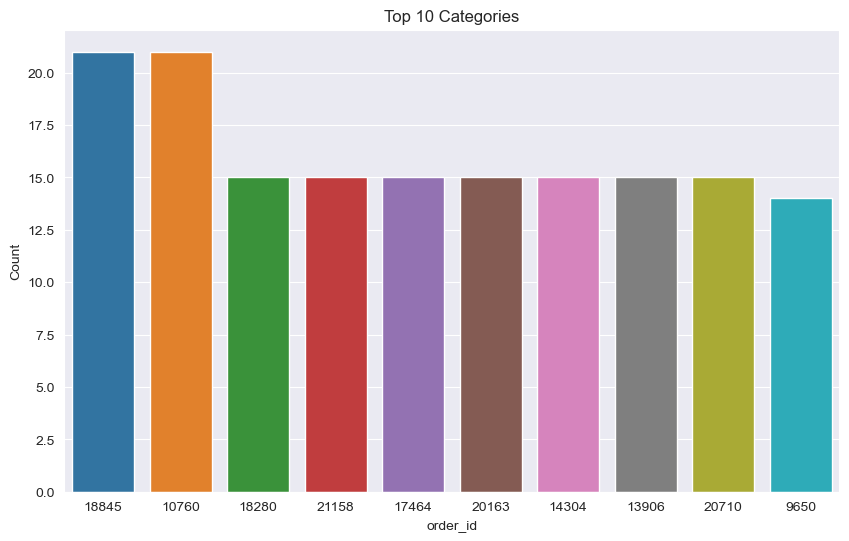

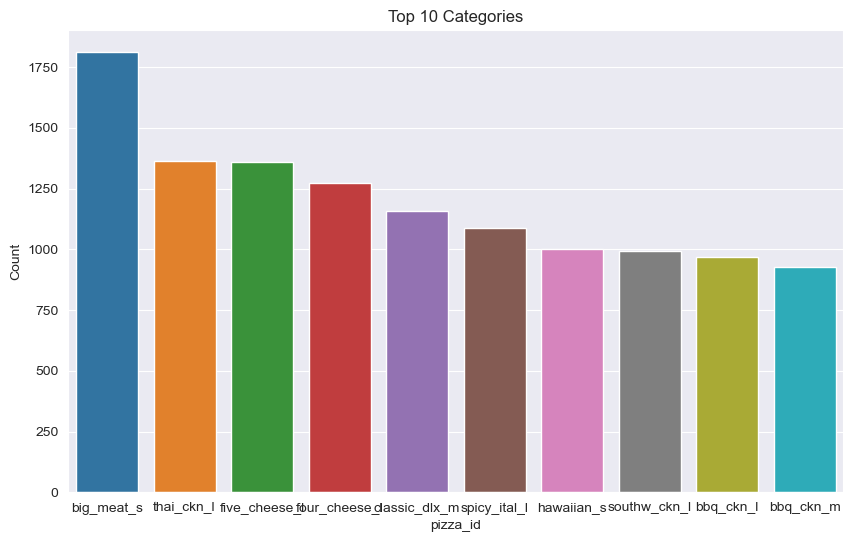

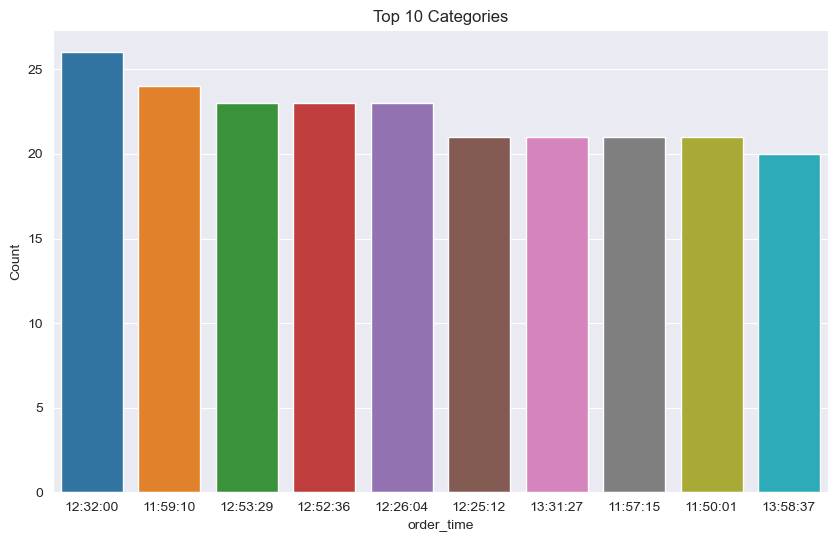

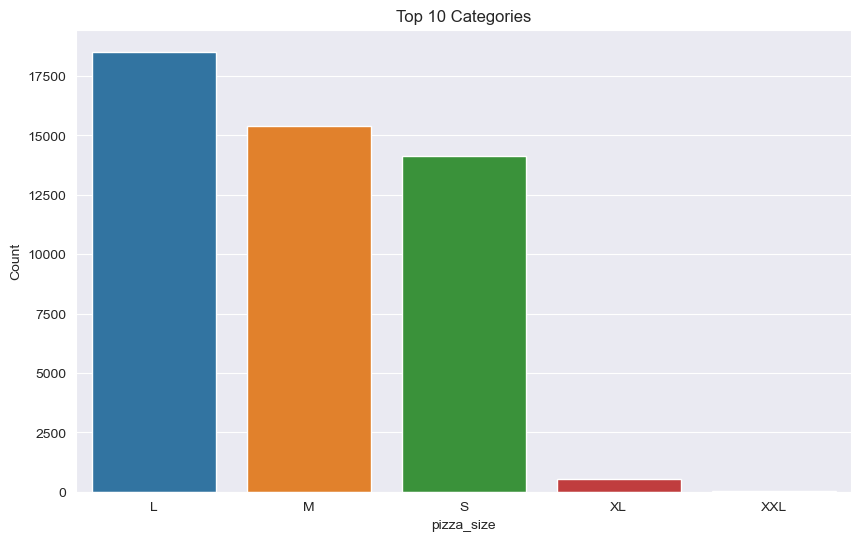

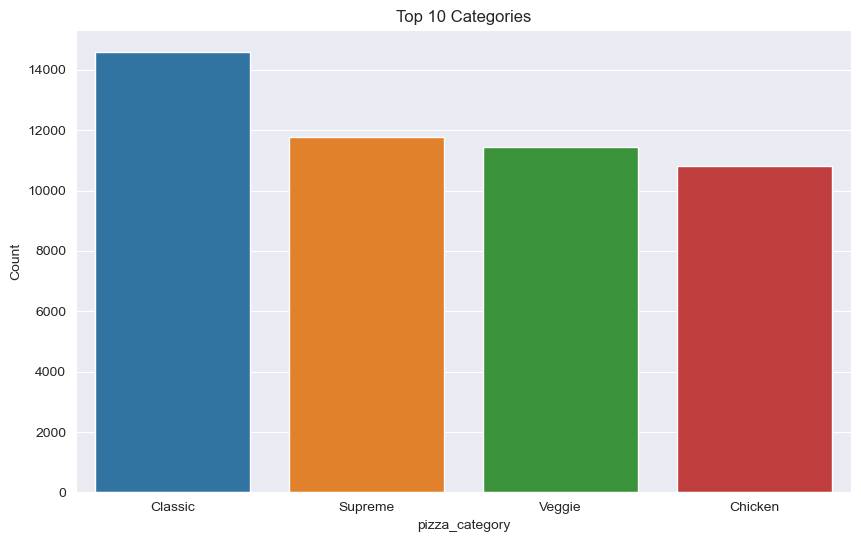

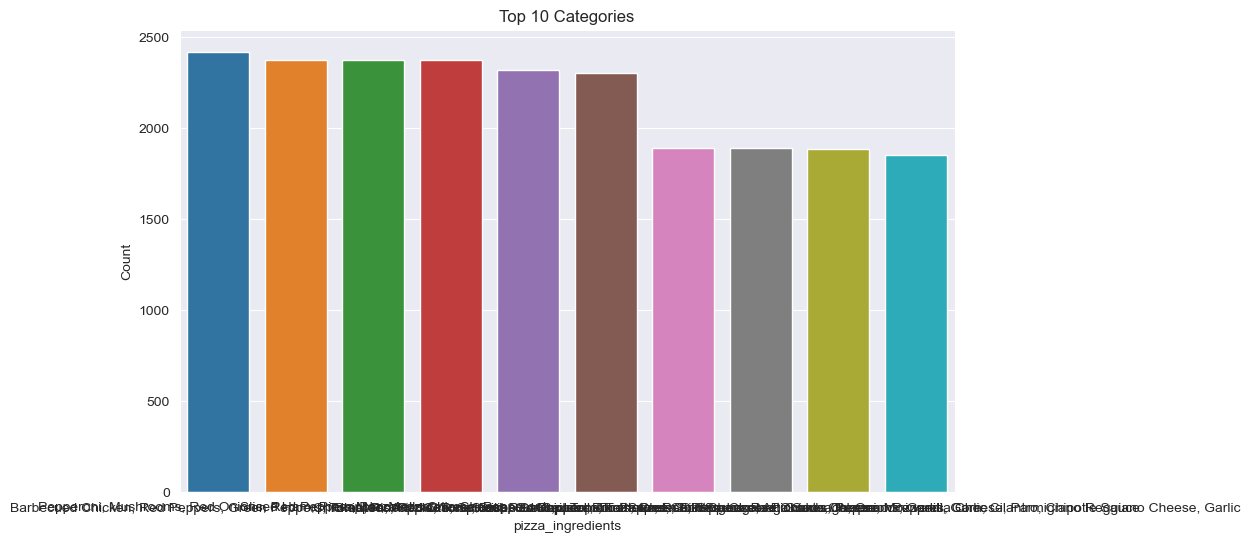

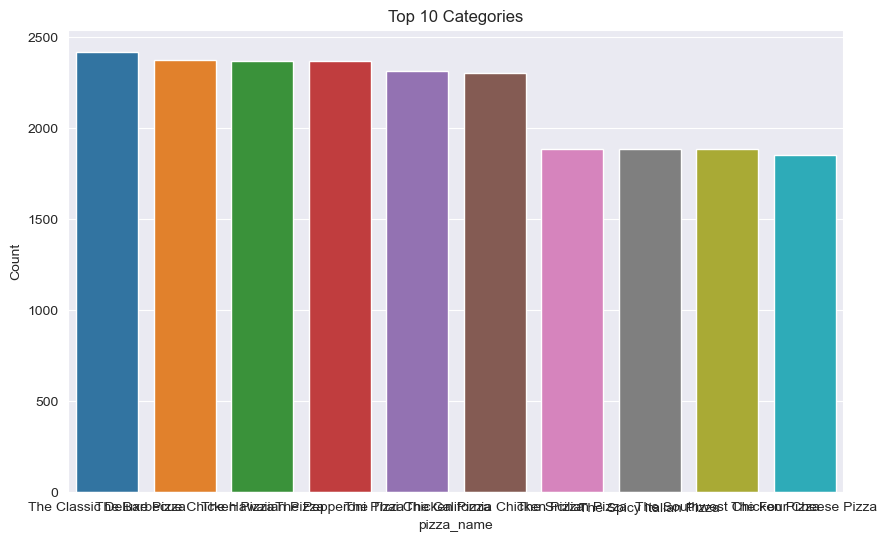

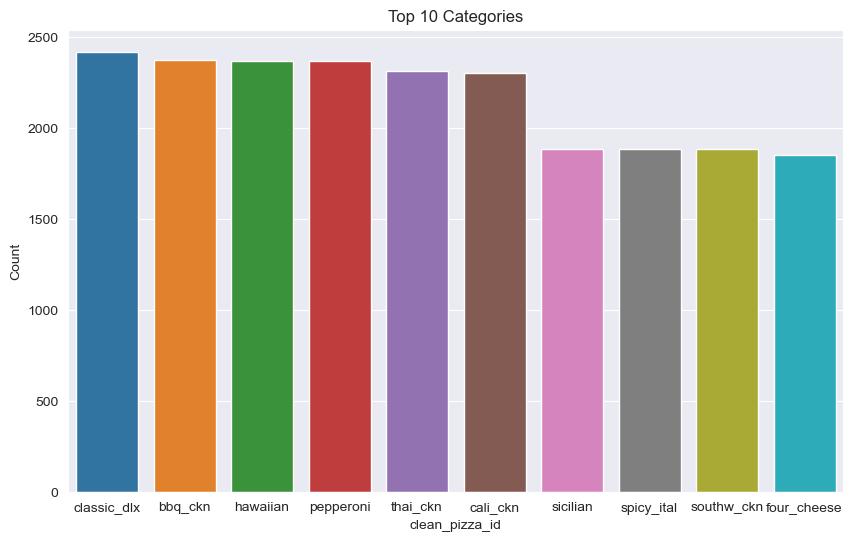

In [21]:
for col in cate_cols.columns:
    plt.figure(figsize=(10, 6))
    category_counts = cate_cols[col].value_counts()

    top_10_categories = category_counts.head(10)
    sns.barplot(x=top_10_categories.index, y=top_10_categories.values)
    plt.title('Top 10 Categories')
    plt.xlabel(f'{col}')
    plt.ylabel('Count')
    plt.show()

In [22]:
int_cols = data.select_dtypes(["float", "int"])
int_cols

,quantity,unit_price,total_price
0,1,13.25,13.25
1,1,16.00,16.00
2,1,18.50,18.50
3,1,20.75,20.75
4,1,16.00,16.00
...,...,...,...
48615,1,16.75,16.75
48616,1,17.95,17.95
48617,1,12.00,12.00
48618,1,20.25,20.25


In [23]:
int_cols.describe()

,quantity,unit_price,total_price
count,48620.000000,48620.000000,48620.000000
mean,1.019622,16.494132,16.821474
std,0.143077,3.621789,4.437398
min,1.000000,9.750000,9.750000
25%,1.000000,12.750000,12.750000
50%,1.000000,16.500000,16.500000
75%,1.000000,20.250000,20.500000
max,4.000000,35.950000,83.000000


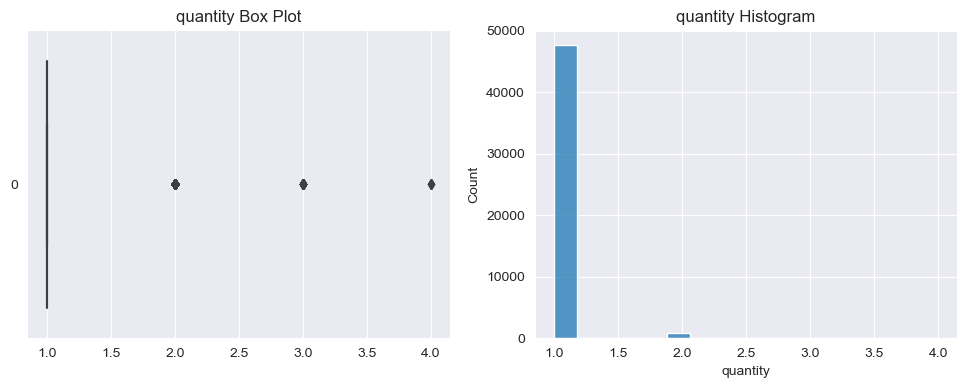

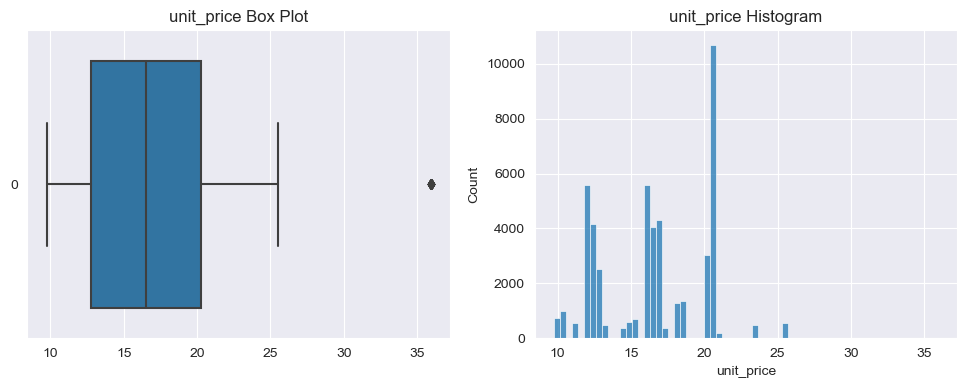

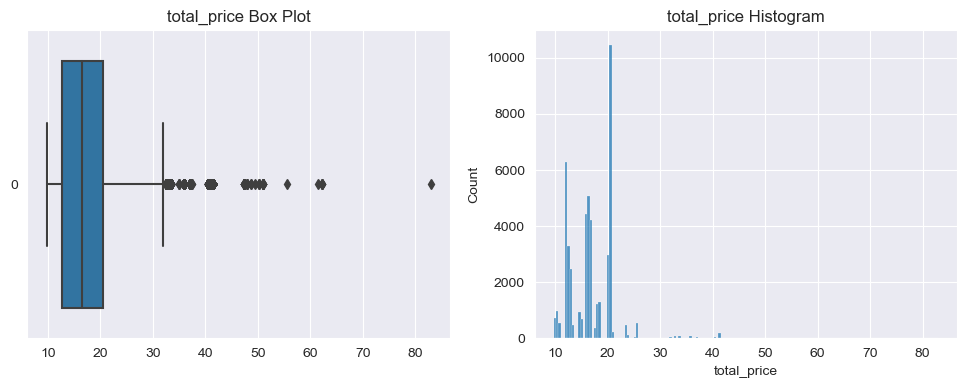

In [24]:
# Iterate through each column
for col in int_cols.columns:
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Plot box plot
    sns.boxplot(int_cols[col], orient="h", ax=axes[0])
    axes[0].set_title(f"{col} Box Plot")

    # Plot histogram
    sns.histplot(int_cols[col], ax=axes[1])
    axes[1].set_title(f"{col} Histogram")

    # Show the plots
    plt.show()

In [25]:
data

,order_id,pizza_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,clean_pizza_id
0,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,hawaiian
1,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,classic_dlx
2,2,five_cheese_l,1,2015-01-01,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza,five_cheese
3,2,ital_supr_l,1,2015-01-01,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza,ital_supr
4,2,mexicana_m,1,2015-01-01,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,mexicana
...,...,...,...,...,...,...,...,...,...,...,...,...
48615,21348,ckn_alfredo_m,1,2015-12-31,21:23:10,16.75,16.75,M,Chicken,"Chicken, Red Onions, Red Peppers, Mushrooms, A...",The Chicken Alfredo Pizza,ckn_alfredo
48616,21348,four_cheese_l,1,2015-12-31,21:23:10,17.95,17.95,L,Veggie,"Ricotta Cheese, Gorgonzola Piccante Cheese, Mo...",The Four Cheese Pizza,four_cheese
48617,21348,napolitana_s,1,2015-12-31,21:23:10,12.00,12.00,S,Classic,"Tomatoes, Anchovies, Green Olives, Red Onions,...",The Napolitana Pizza,napolitana
48618,21349,mexicana_l,1,2015-12-31,22:09:54,20.25,20.25,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,mexicana


In [26]:
units_sold_by_item = data.groupby(["sku_id"], as_index=False).agg({'units_sold': 'sum'})
units_sold_by_item

KeyError: 'sku_id'

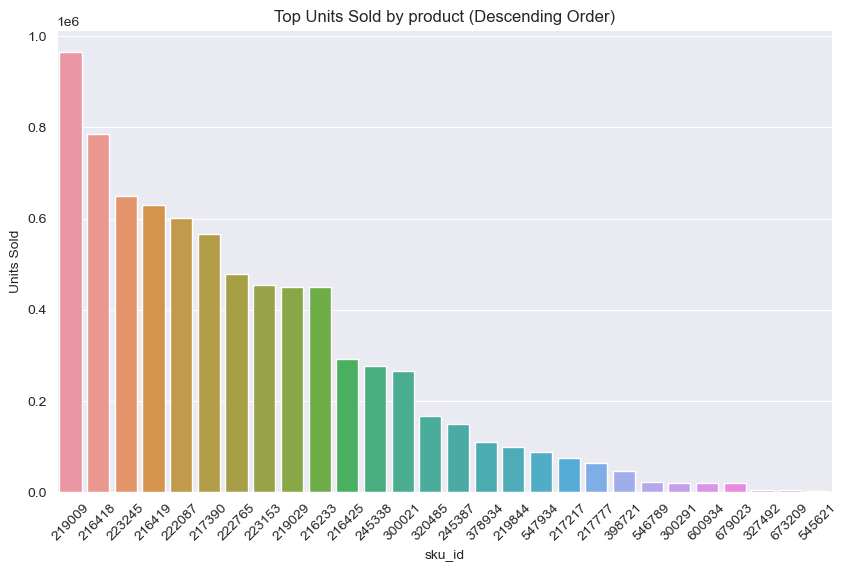

In [24]:
# Sort the DataFrame by 'units_sold' in descending order
units_sold_by_item_sorted = units_sold_by_item.sort_values(by='units_sold', ascending=False)

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x="sku_id", y="units_sold", data=units_sold_by_item_sorted)
plt.title('Top Units Sold by product (Descending Order)')
plt.xlabel('sku_id')
plt.ylabel('Units Sold')
plt.xticks(rotation=45)

plt.show()

In [27]:
data

,order_id,pizza_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,clean_pizza_id
0,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,hawaiian
1,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,classic_dlx
2,2,five_cheese_l,1,2015-01-01,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza,five_cheese
3,2,ital_supr_l,1,2015-01-01,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza,ital_supr
4,2,mexicana_m,1,2015-01-01,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,mexicana
...,...,...,...,...,...,...,...,...,...,...,...,...
48615,21348,ckn_alfredo_m,1,2015-12-31,21:23:10,16.75,16.75,M,Chicken,"Chicken, Red Onions, Red Peppers, Mushrooms, A...",The Chicken Alfredo Pizza,ckn_alfredo
48616,21348,four_cheese_l,1,2015-12-31,21:23:10,17.95,17.95,L,Veggie,"Ricotta Cheese, Gorgonzola Piccante Cheese, Mo...",The Four Cheese Pizza,four_cheese
48617,21348,napolitana_s,1,2015-12-31,21:23:10,12.00,12.00,S,Classic,"Tomatoes, Anchovies, Green Olives, Red Onions,...",The Napolitana Pizza,napolitana
48618,21349,mexicana_l,1,2015-12-31,22:09:54,20.25,20.25,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,mexicana


In [28]:
units_sold_by_store = data.groupby(["store_id"], as_index=False).agg({'units_sold': 'sum'})

# Sort the DataFrame by 'units_sold' in descending order
units_sold_by_store_sorted = units_sold_by_store.sort_values(by='units_sold', ascending=False).head(15)

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x="store_id", y="units_sold", data=units_sold_by_store_sorted)
plt.title('Top Units Sold by stores 15')
plt.xlabel('store_id')
plt.ylabel('Units Sold')
plt.xticks(rotation=45)

plt.show()

KeyError: 'store_id'

In [29]:
data.head(1)

,order_id,pizza_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,clean_pizza_id
0,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,hawaiian


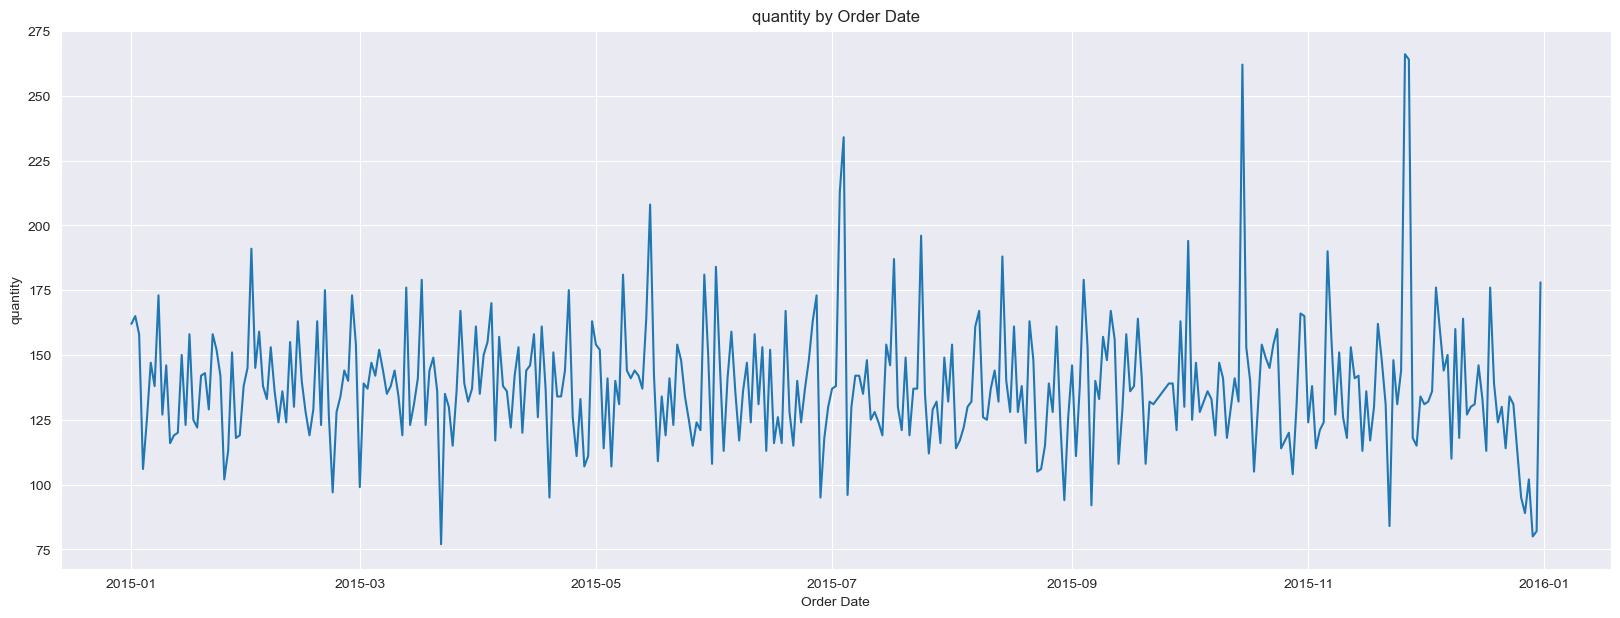

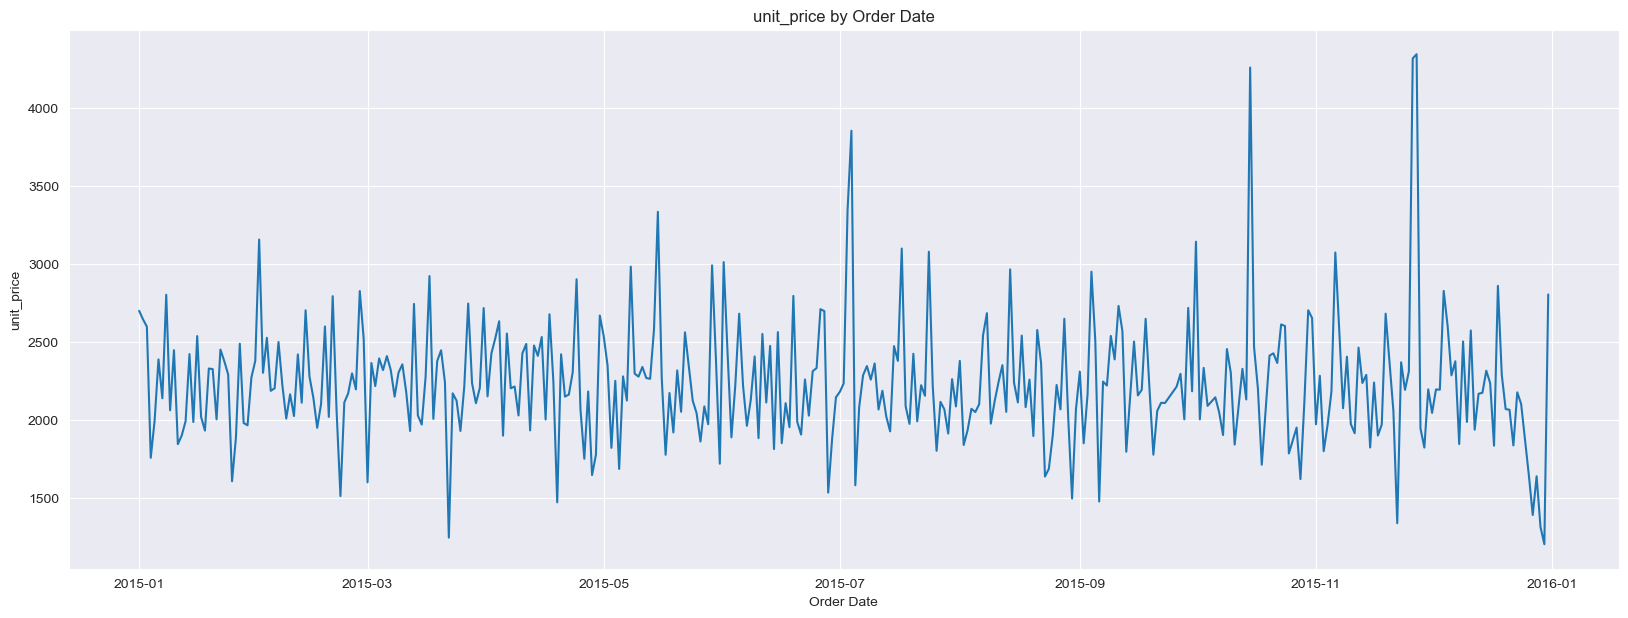

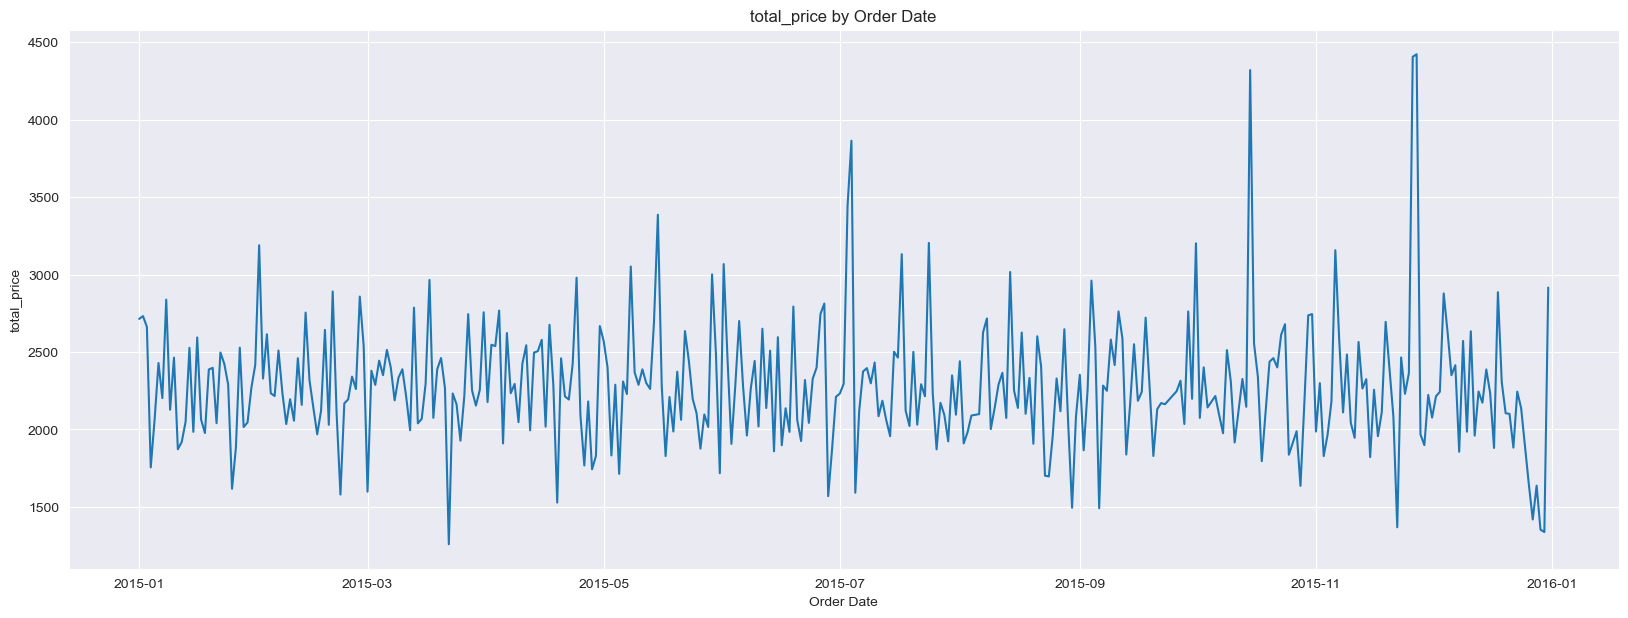

In [30]:
grouped_by_date = data.groupby('order_date').sum(numeric_only=True)
for col in grouped_by_date.columns:
    plt.figure(figsize=(20, 7))
    sns.lineplot(data=grouped_by_date, x="order_date", y=col)
    plt.xlabel("Order Date")
    plt.ylabel(f"{col}")
    plt.title(f"{col} by Order Date")
    plt.show()

In [31]:
data.head(2)

,order_id,pizza_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,clean_pizza_id
0,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,hawaiian
1,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,classic_dlx


In [32]:
# transforming the dates from daily to weekly
data['Week_Start'] = data['order_date'] - pd.to_timedelta(data['order_date'].dt.dayofweek, unit='D')

# Group by the week start and aggregate the minimum order_date
data['Week_Start'] = data.groupby('Week_Start')['order_date'].transform('min')

# Drop unnecessary columns
data.drop(['order_date'], axis=1, inplace=True)
data.drop_duplicates(inplace=True)


In [33]:
grouped_by_pizza = data.groupby(["pizza_id"], as_index=False).agg({"Week_Start": ['nunique', 'max', 'min']})
grouped_by_pizza

pizza_id Week_Start                      
                     nunique        max        min
0       bbq_ckn_l         53 2015-12-28 2015-01-01
1       bbq_ckn_m         53 2015-12-28 2015-01-01
2       bbq_ckn_s         53 2015-12-28 2015-01-01
3      big_meat_s         53 2015-12-28 2015-01-01
4    brie_carre_s         53 2015-12-28 2015-01-01
..            ...        ...        ...        ...
86   the_greek_xl         53 2015-12-28 2015-01-01
87  the_greek_xxl         22 2015-12-14 2015-01-26
88   veggie_veg_l         53 2015-12-28 2015-01-01
89   veggie_veg_m         53 2015-12-28 2015-01-01
90   veggie_veg_s         53 2015-12-28 2015-01-01

[91 rows x 4 columns]

All items have different weeks!

In [34]:
12/ 52

0.23076923076923078

In [35]:
data.head(2)

,order_id,pizza_id,quantity,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,clean_pizza_id,Week_Start
0,1,hawaiian_m,1,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,hawaiian,2015-01-01
1,2,classic_dlx_m,1,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,classic_dlx,2015-01-01


In [36]:
# for demo purpose
slice_data = data[['order_id', 'Week_Start', 'pizza_id', 'quantity', 'unit_price', 'total_price']]
slice_data

,order_id,Week_Start,pizza_id,quantity,unit_price,total_price
0,1,2015-01-01,hawaiian_m,1,13.25,13.25
1,2,2015-01-01,classic_dlx_m,1,16.00,16.00
2,2,2015-01-01,five_cheese_l,1,18.50,18.50
3,2,2015-01-01,ital_supr_l,1,20.75,20.75
4,2,2015-01-01,mexicana_m,1,16.00,16.00
...,...,...,...,...,...,...
48615,21348,2015-12-28,ckn_alfredo_m,1,16.75,16.75
48616,21348,2015-12-28,four_cheese_l,1,17.95,17.95
48617,21348,2015-12-28,napolitana_s,1,12.00,12.00
48618,21349,2015-12-28,mexicana_l,1,20.25,20.25


In [37]:
slice_data.to_csv("./data/processed/data.csv", index=False)

In [38]:

order_date_column = 'Week_Start'
data_sorted = data.sort_values(by=order_date_column, ascending=False)
# Remove duplicate dates and select the last 20 unique dates
last_20_dates = data_sorted[order_date_column].drop_duplicates().head(12)

train = data[~data[order_date_column].isin(last_20_dates)]
test = data[data[order_date_column].isin(last_20_dates)]

In [39]:
data_for_demo = slice_data[slice_data[order_date_column].isin(last_20_dates)]
data_for_demo.to_csv("./data/processed/demo_data.csv", index=False)

In [40]:
data_for_demo.head(4)

,order_id,Week_Start,pizza_id,quantity,unit_price,total_price
38132,16825,2015-10-13,five_cheese_l,1,18.50,18.50
38133,16825,2015-10-13,prsc_argla_s,1,12.50,12.50
38134,16825,2015-10-13,spinach_fet_l,1,20.25,20.25
38135,16825,2015-10-13,thai_ckn_s,1,12.75,12.75


In [41]:
data_for_demo[data_for_demo['pizza_id'] == "bbq_ckn_s"]

,order_id,Week_Start,pizza_id,quantity,unit_price,total_price
38154,16835,2015-10-13,bbq_ckn_s,1,12.75,12.75
38218,16858,2015-10-13,bbq_ckn_s,1,12.75,12.75
38275,16885,2015-10-13,bbq_ckn_s,1,12.75,12.75
38366,16923,2015-10-13,bbq_ckn_s,1,12.75,12.75
38687,17054,2015-10-13,bbq_ckn_s,1,12.75,12.75
...,...,...,...,...,...,...
48031,21115,2015-12-21,bbq_ckn_s,1,12.75,12.75
48054,21122,2015-12-21,bbq_ckn_s,1,12.75,12.75
48293,21216,2015-12-28,bbq_ckn_s,1,12.75,12.75
48419,21261,2015-12-28,bbq_ckn_s,1,12.75,12.75


In [42]:
# saving almsot same version as above but without quantity
data_for_demo.drop('quantity', axis=1).to_csv("./data/processed/demo_test_data.csv", index=False)

In [43]:
train[order_date_column].nunique(), test[order_date_column].nunique()

(41, 12)

In [44]:
train['pizza_id'].nunique(), test['pizza_id'].nunique()

(91, 91)

In [45]:
train['pizza_name'].nunique(), test['pizza_name'].nunique()

(32, 32)

- We have 41 weeks for training.
- We have 12 weeks for testing.

Does prices vary between in the year?

In [46]:
for pizza in data['pizza_id'].unique():
    temp = data[data['pizza_id'] == pizza]
    if temp['unit_price'].nunique() > 1:
        print(pizza)

- Convert dates from daily to weekly.
- Feature used
    -  `pizza_id`
    - `unit_price`, price is the same for same unit
    - extracting from `Week_Start` day, month and year as additional features
- Target is sum of `quantity`

In [47]:
train.dtypes

order_id                     object
pizza_id                     object
quantity                      int64
order_time                   object
unit_price                  float64
total_price                 float64
pizza_size                   object
pizza_category               object
pizza_ingredients            object
pizza_name                   object
clean_pizza_id               object
Week_Start           datetime64[ns]
dtype: object

In [48]:
train.head(1)

,order_id,pizza_id,quantity,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,clean_pizza_id,Week_Start
0,1,hawaiian_m,1,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,hawaiian,2015-01-01


In [49]:
aggregated_dict = {'quantity': 'sum', 'unit_price': 'max'}

train_by_product = train.groupby(["pizza_id", "Week_Start"], as_index=False).agg(aggregated_dict)
test_by_product = test.groupby(["pizza_id", "Week_Start"], as_index=False).agg(aggregated_dict)

train_by_product

,pizza_id,Week_Start,quantity,unit_price
0,bbq_ckn_l,2015-01-01,18,20.75
1,bbq_ckn_l,2015-01-05,13,20.75
2,bbq_ckn_l,2015-01-12,25,20.75
3,bbq_ckn_l,2015-01-19,15,20.75
4,bbq_ckn_l,2015-01-26,29,20.75
...,...,...,...,...
3677,veggie_veg_s,2015-09-07,8,12.00
3678,veggie_veg_s,2015-09-14,12,12.00
3679,veggie_veg_s,2015-09-21,1,12.00
3680,veggie_veg_s,2015-09-28,4,12.00


In [50]:
def extract_date_features(df, date_column):
    """
    Extract day, month, and year as features from a date column in a DataFrame.

    Parameters:
    - df: Pandas DataFrame
    - date_column: Name of the date column in the DataFrame

    Returns:
    - DataFrame with additional columns for day, month, and year
    """
    # Convert the date column to datetime format
    df[date_column] = pd.to_datetime(df[date_column])

    # Extract day, month, and year features
    df['day'] = df[date_column].dt.day
    df['month'] = df[date_column].dt.month
    df['year'] = df[date_column].dt.year

    return df

# Example usage:
# Assuming df is your DataFrame with a column named 'date_column'
train_by_product = extract_date_features(train_by_product, date_column=order_date_column)
test_by_product = extract_date_features(test_by_product, date_column=order_date_column)

## Machine learning apporach

In [51]:
train_by_product

,pizza_id,Week_Start,quantity,unit_price,day,month,year
0,bbq_ckn_l,2015-01-01,18,20.75,1,1,2015
1,bbq_ckn_l,2015-01-05,13,20.75,5,1,2015
2,bbq_ckn_l,2015-01-12,25,20.75,12,1,2015
3,bbq_ckn_l,2015-01-19,15,20.75,19,1,2015
4,bbq_ckn_l,2015-01-26,29,20.75,26,1,2015
...,...,...,...,...,...,...,...
3677,veggie_veg_s,2015-09-07,8,12.00,7,9,2015
3678,veggie_veg_s,2015-09-14,12,12.00,14,9,2015
3679,veggie_veg_s,2015-09-21,1,12.00,21,9,2015
3680,veggie_veg_s,2015-09-28,4,12.00,28,9,2015


In [52]:
cols_to_encode = ['pizza_id']

cols_to_drop = ['Week_Start']

In [53]:
from sklearn.preprocessing import OneHotEncoder

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False, drop='first')  # drop='first' removes the first category to avoid multicollinearity

# Fit and transform the data
encoded_data = encoder.fit_transform(train_by_product[cols_to_encode])

# Create a DataFrame with the encoded data
df_encoded = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(cols_to_encode))

# Concatenate the original DataFrame with the one-hot encoded DataFrame
train_encoded = pd.concat([train_by_product, df_encoded], axis=1)

# Drop the original categorical column if needed
train_encoded.drop(cols_to_encode, axis=1, inplace=True)

train_encoded.drop(cols_to_drop, axis=1, inplace=True)

train_encoded.head(3)

c:\Users\user\miniconda3\envs\desaisiv\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,quantity,unit_price,day,month,year,pizza_id_bbq_ckn_m,pizza_id_bbq_ckn_s,pizza_id_big_meat_s,pizza_id_brie_carre_s,pizza_id_calabrese_l,...,pizza_id_thai_ckn_m,pizza_id_thai_ckn_s,pizza_id_the_greek_l,pizza_id_the_greek_m,pizza_id_the_greek_s,pizza_id_the_greek_xl,pizza_id_the_greek_xxl,pizza_id_veggie_veg_l,pizza_id_veggie_veg_m,pizza_id_veggie_veg_s
0,18,20.75,1,1,2015,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,13,20.75,5,1,2015,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,25,20.75,12,1,2015,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
# Fit and transform the data
encoded_data = encoder.transform(test_by_product[cols_to_encode])

# Create a DataFrame with the encoded data
df_encoded = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(cols_to_encode))

# Concatenate the original DataFrame with the one-hot encoded DataFrame
test_encoded = pd.concat([test_by_product, df_encoded], axis=1)

# Drop the original categorical column if needed
test_encoded.drop(cols_to_encode, axis=1, inplace=True)

test_encoded.drop(cols_to_drop, axis=1, inplace=True)

test_encoded.head(3)

,quantity,unit_price,day,month,year,pizza_id_bbq_ckn_m,pizza_id_bbq_ckn_s,pizza_id_big_meat_s,pizza_id_brie_carre_s,pizza_id_calabrese_l,...,pizza_id_thai_ckn_m,pizza_id_thai_ckn_s,pizza_id_the_greek_l,pizza_id_the_greek_m,pizza_id_the_greek_s,pizza_id_the_greek_xl,pizza_id_the_greek_xxl,pizza_id_veggie_veg_l,pizza_id_veggie_veg_m,pizza_id_veggie_veg_s
0,15,20.75,13,10,2015,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12,20.75,20,10,2015,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13,20.75,27,10,2015,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
target_col = 'quantity'
X_train = train_encoded.drop(target_col, axis=1)
y_train = train_encoded[target_col]


X_test = test_encoded.drop(target_col, axis=1)
y_test = test_encoded[target_col]

In [56]:
X_test.head(1)

,unit_price,day,month,year,pizza_id_bbq_ckn_m,pizza_id_bbq_ckn_s,pizza_id_big_meat_s,pizza_id_brie_carre_s,pizza_id_calabrese_l,pizza_id_calabrese_m,...,pizza_id_thai_ckn_m,pizza_id_thai_ckn_s,pizza_id_the_greek_l,pizza_id_the_greek_m,pizza_id_the_greek_s,pizza_id_the_greek_xl,pizza_id_the_greek_xxl,pizza_id_veggie_veg_l,pizza_id_veggie_veg_m,pizza_id_veggie_veg_s
0,20.75,13,10,2015,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
scaler = MinMaxScaler()
X_train_scaled =  scaler.fit_transform(X_train)
X_test_scaled =  scaler.transform(X_test)

In [58]:
def evaluate_model(model_df, i, model_name, model, X_train, X_test, y_train, y_test):
    """
    this function is for regression takes the model with the data and calculate
    the scores, with cross validation techniques, in addition to MAE, MSE, RMSE, MAPE
    R Squared and Adjusted R Squared

    :param model: model
    :param X_train, X_test, y_train, y_test: data that was used
    """
    # cross validation with 5 folds
    # all_cv_5 = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

    # predictions from our model
    predictions = model.predict(X_test)

    # round so predictions don't have fractures  - decimenal points
    predictions = np.round(predictions)
    # calculating R squared and Adjusted R squared
    # r_sqre = r2_score(y_test, predictions)
    # n = len(y_test)
    # p = X_test[0].shape[0] # number of independant features

    # Adj_r2 = 1-(1-r_sqre)*(n-1)/(n-p-1)
    
    test_mae = mean_absolute_error(y_test, predictions)

    test_mse = mean_squared_error(y_test, predictions)

    test_rmse = np.sqrt(mean_squared_error(y_test, predictions))

    test_mape = mean_absolute_percentage_error(y_test, predictions)

    print("=" * 40)
    model_df.loc[i] = [model_name, test_mae, test_mape,
                       test_mse, test_rmse]

    return model_df

In [59]:
SEED = 42
np.random.seed(SEED)

models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'XGBoost': xgb.XGBRegressor(),
    "GBR": GradientBoostingRegressor(),
    'CatBoost': catboost.CatBoostRegressor(iterations=1000, verbose=0, allow_writing_files=False),
    'LightGBM': lgb.LGBMRegressor()
}

models_scores_df = pd.DataFrame(columns=["model", "MAE", "MAPE", "MSE",
                                          "RMSE"])

for i, model_name in enumerate(models):

    # getting the name of our model
    pipeline = models[model_name]
    print(model_name)
    
    # fitting our data
    pipeline.fit(X_train_scaled, y_train)
    evaluate_model(models_scores_df, i, model_name, pipeline, X_train_scaled, X_test_scaled, y_train, y_test)


Linear Regression
Decision Tree
XGBoost
GBR
CatBoost
LightGBM
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 244
[LightGBM] [Info] Number of data points in the train set: 3682, number of used features: 92
[LightGBM] [Info] Start training from score 10.558935


In [60]:
# normalization
models_scores_df

,model,MAE,MAPE,MSE,RMSE
0,Linear Regression,2.919701,0.491606,15.141923,3.891262
1,Decision Tree,4.056956,0.593167,29.293184,5.412318
2,XGBoost,3.250233,0.477040,19.364146,4.400471
3,GBR,3.579832,0.698800,20.100840,4.483396
4,CatBoost,3.093371,0.448932,17.343604,4.164565
5,LightGBM,3.070962,0.453249,16.947712,4.116760


In [61]:
np.round(models['Linear Regression'].predict(X_test_scaled))

array([19., 19., 19., ...,  9.,  9.,  9.])

In [62]:
y_test

0       15
1       12
2       13
3       22
4       19
        ..
1066    12
1067     9
1068     6
1069     6
1070     9
Name: quantity, Length: 1071, dtype: int64

- Best model at predicting next 12 weeks is Decision Tree.
- On Average the units predicted are off by **3** units.

### Making a pipeline, "best practice"

In [63]:
train

,order_id,pizza_id,quantity,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,clean_pizza_id,Week_Start
0,1,hawaiian_m,1,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,hawaiian,2015-01-01
1,2,classic_dlx_m,1,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,classic_dlx,2015-01-01
2,2,five_cheese_l,1,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza,five_cheese,2015-01-01
3,2,ital_supr_l,1,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza,ital_supr,2015-01-01
4,2,mexicana_m,1,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,mexicana,2015-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...
38127,16823,sicilian_m,1,21:20:59,16.25,16.25,M,Supreme,"Coarse Sicilian Salami, Tomatoes, Green Olives...",The Sicilian Pizza,sicilian,2015-10-06
38128,16823,spin_pesto_s,1,21:20:59,12.50,12.50,S,Veggie,"Spinach, Artichokes, Tomatoes, Sun-dried Tomat...",The Spinach Pesto Pizza,spin_pesto,2015-10-06
38129,16823,the_greek_m,1,21:20:59,16.00,16.00,M,Classic,"Kalamata Olives, Feta Cheese, Tomatoes, Garlic...",The Greek Pizza,the_greek,2015-10-06
38130,16824,mediterraneo_s,1,21:48:42,12.00,12.00,S,Veggie,"Spinach, Artichokes, Kalamata Olives, Sun-drie...",The Mediterranean Pizza,mediterraneo,2015-10-06


In [64]:
train_by_product

,pizza_id,Week_Start,quantity,unit_price,day,month,year
0,bbq_ckn_l,2015-01-01,18,20.75,1,1,2015
1,bbq_ckn_l,2015-01-05,13,20.75,5,1,2015
2,bbq_ckn_l,2015-01-12,25,20.75,12,1,2015
3,bbq_ckn_l,2015-01-19,15,20.75,19,1,2015
4,bbq_ckn_l,2015-01-26,29,20.75,26,1,2015
...,...,...,...,...,...,...,...
3677,veggie_veg_s,2015-09-07,8,12.00,7,9,2015
3678,veggie_veg_s,2015-09-14,12,12.00,14,9,2015
3679,veggie_veg_s,2015-09-21,1,12.00,21,9,2015
3680,veggie_veg_s,2015-09-28,4,12.00,28,9,2015


In [65]:
def preprocess_df(df, date_col):
    aggregated_dict = {'quantity': 'sum', 'unit_price': 'max'}

    processed_df = df.groupby(["pizza_id", date_col], as_index=False).agg(aggregated_dict)

    # extract day, month and year
    processed_df = extract_date_features(processed_df, date_col)

    processed_df = processed_df.drop(date_col, axis=1)
    return processed_df

In [66]:
br = preprocess_df(train, date_col='Week_Start')
br

,pizza_id,quantity,unit_price,day,month,year
0,bbq_ckn_l,18,20.75,1,1,2015
1,bbq_ckn_l,13,20.75,5,1,2015
2,bbq_ckn_l,25,20.75,12,1,2015
3,bbq_ckn_l,15,20.75,19,1,2015
4,bbq_ckn_l,29,20.75,26,1,2015
...,...,...,...,...,...,...
3677,veggie_veg_s,8,12.00,7,9,2015
3678,veggie_veg_s,12,12.00,14,9,2015
3679,veggie_veg_s,1,12.00,21,9,2015
3680,veggie_veg_s,4,12.00,28,9,2015


In [67]:
br_x = br.drop('quantity', axis=1)
br_y = br['quantity']

In [68]:
target_col = 'quantity'

# Assuming you have numerical and categorical features
numerical_features = ['unit_price', 'day', 'month', 'year']
categorical_features = ['pizza_id']

# Create transformers for numerical and categorical features
numerical_transformer = MinMaxScaler()
categorical_transformer = OneHotEncoder()

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Add the model to the pipeline
model = LinearRegression()
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])


In [69]:
np.random.seed(SEED)
pipeline.fit(br_x, br_y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['unit_price', 'day', 'month',
                                                   'year']),
                                                 ('cat', OneHotEncoder(),
                                                  ['pizza_id'])])),
                ('model', LinearRegression())])

In [70]:
br_test = preprocess_df(test, date_col='Week_Start')
br_test

,pizza_id,quantity,unit_price,day,month,year
0,bbq_ckn_l,15,20.75,13,10,2015
1,bbq_ckn_l,12,20.75,20,10,2015
2,bbq_ckn_l,13,20.75,27,10,2015
3,bbq_ckn_l,22,20.75,2,11,2015
4,bbq_ckn_l,19,20.75,9,11,2015
...,...,...,...,...,...,...
1066,veggie_veg_s,12,12.00,30,11,2015
1067,veggie_veg_s,9,12.00,7,12,2015
1068,veggie_veg_s,6,12.00,14,12,2015
1069,veggie_veg_s,6,12.00,21,12,2015


In [71]:
br_test

,pizza_id,quantity,unit_price,day,month,year
0,bbq_ckn_l,15,20.75,13,10,2015
1,bbq_ckn_l,12,20.75,20,10,2015
2,bbq_ckn_l,13,20.75,27,10,2015
3,bbq_ckn_l,22,20.75,2,11,2015
4,bbq_ckn_l,19,20.75,9,11,2015
...,...,...,...,...,...,...
1066,veggie_veg_s,12,12.00,30,11,2015
1067,veggie_veg_s,9,12.00,7,12,2015
1068,veggie_veg_s,6,12.00,14,12,2015
1069,veggie_veg_s,6,12.00,21,12,2015


In [72]:
br_test_real = br_test[target_col]
br_test = br_test.drop(target_col, axis=1)

In [73]:
br_test

,pizza_id,unit_price,day,month,year
0,bbq_ckn_l,20.75,13,10,2015
1,bbq_ckn_l,20.75,20,10,2015
2,bbq_ckn_l,20.75,27,10,2015
3,bbq_ckn_l,20.75,2,11,2015
4,bbq_ckn_l,20.75,9,11,2015
...,...,...,...,...,...
1066,veggie_veg_s,12.00,30,11,2015
1067,veggie_veg_s,12.00,7,12,2015
1068,veggie_veg_s,12.00,14,12,2015
1069,veggie_veg_s,12.00,21,12,2015


In [74]:
mean_absolute_error(br_test_real, np.round(pipeline.predict(br_test)))

2.911297852474323

### Saving the Pipeline

In [75]:
import pickle
# Save the pipeline

joblib.dump(pipeline, './artifacts/model_pipeline.joblib')
with open('./artifacts/model.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

# Load the pipeline
loaded_pipeline = joblib.load('./artifacts/model_pipeline.joblib')

In [77]:
with open('./artifacts/model.pkl', 'rb') as file:
    l_p = pickle.load(file)

In [179]:
np.round(loaded_pipeline.predict(br_test))

array([19., 19., 19., ...,  9.,  9.,  9.])